### This script downloads the ECMWF IFS 3-hourly temperature forecast at 0.25 global gridded from ECMWF Open Data and aggregates it to daily mean temperature at LSOA-level (required for the epidemiological analysis described in Mistry & Gasparrini, 2024). The forecast dates and the lead times can be chosen in the ECMWF opendata function.

#### Last updated 27-June-2025 - Malcolm N. Mistry

#### Attribution The following wording should be attached to the use of this ECMWF dataset:  Copyright statement: Copyright "© [year] European Centre for Medium-Range Weather Forecasts (ECMWF)".
Source www.ecmwf.int
Licence Statement: This data is published under a Creative Commons Attribution 4.0 International (CC BY 4.0). https://creativecommons.org/licenses/by/4.0/
Disclaimer: ECMWF does not accept any liability whatsoever for any error or omission in the data, their availability, or for any loss or damage arising from their use.
Where applicable, an indication if the material has been modified and an indication of previous modifications.
The following wording shall be attached to services created with this ECMWF dataset:
Copyright statement: Copyright "This service is based on data and products of the European Centre for Medium-Range Weather Forecasts (ECMWF)".
Source www.ecmwf.int
Licence Statement: This ECMWF data is published under a Creative Commons Attribution 4.0 International (CC BY 4.0). https://creativecommons.org/licenses/by/4.0/
Disclaimer: ECMWF does not accept any liability whatsoever for any error or omission in the data, their availability, or for any loss or damage arising from their use.
Where applicable, an indication if the material has been modified and an indication of previous modifications

### More information on the ECMWF opendata package
#### https://github.com/ecmwf/ecmwf-opendata  and  https://www.ecmwf.int/en/forecasts/datasets/open-data

In [52]:
import os
import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwfapi import *
import requests
from ecmwf.opendata import Client
import xarray as xr
import geopandas as gpd
import pandas as pd
from exactextract import exact_extract  # For aggregating the grid cell data to spatial boundaries (here using area-weighting)
import numpy as np
import cfgrib
import requests
import zipfile
import tempfile
import matplotlib.pyplot as plt
import rasterio
import rioxarray

### Set path to home directory, data directory where the ECMWF forecast data will be stored, and input shape files that will be used for LSOA-level aggregation of daily Tmean data

In [2]:
home_dir = os.path.join(os.path.expanduser("~"), "Projects/ECMWF_forecast/")
data_dir = os.path.join(home_dir, "data/")
shape_dir = os.path.join(home_dir, "shape_file/")
csv_dir = os.path.join(data_dir, "csv/")
output_csv_filename = csv_dir + 'daily_tasmean_ecmwf_forecast_lsoa_aggr.csv'

### Change the path to output_data_dir to save the downloaded ECMWF files

In [3]:
%cd $data_dir

/home/lshmm22/Projects/ECMWF_forecast/data


### Check the latest available forecast if the most recent forecast is desired to be downloaded. The output of the below block of code returns the date and time of the most recent matching forecast without downloading the data.  All date and time are expressed in UTC. 'model' is the name of the model that produced the data. Use ifs for the physics-driven model, aifs-single for the data-driven model, and aifs-ens for the ensemble data-driven model. Default is ifs.

In [4]:
client = Client(source="ecmwf")

print(client.latest(
    model="ifs",
    resol="0p25",
    type="fc",
    param="2t"
))

2025-06-30 18:00:00


#### The Client.retrieve() method below takes the same parameters as the Client.latest() method to retrive the required data. If time and date parameters are not defined, the query will automatically retrieve the most recent available data as returned by the above block of code. The target parameter is the path/file where the queried data will be downloaded in a grib2 file format. So the example below will download the most recent forecast in a file 'temperary_file.grib2' but only for 1st time step, i.e., if the most recent forecast is issued at time 0000h UTC, the forecast time step will be for 0000h. Likewise, if the forecast is issued at time 0600h, the time step if 0 will result in the forecast data for 0600h UTC being downloaded. Note that the time steps need be in steps of 3hours ..so 0, 3, 6 ...and so on for upto 144 hours, and then in 6 hour steps (see Documentation).

In [5]:
client = Client(source="ecmwf")

result=client.retrieve(
    #time=0,
    #date=0,
    model="ifs",
    resol="0p25",
    type="fc",
    step=0,          # the forecast time step in hours, default is 0
    param="2t",
    target="grib2/temporary_file.grib2",
)

print(result.datetime)

2025-06-30 00:00:00


### Now download the 3hrly temperature data starting from a user defined start and end date/time. Here, as example, the forecast issued at 00h UTC on the 19June2025 on a lead time of 6 days (24h x 6 = 144 hrs).  Create a list of 3 hourly sequence for total 6 days starting from 03h. Since each day will have 8 x '3hrly timesteps' (03-24h), 6 days would require the sequence to end at 144

In [5]:
hour_steps = [*range(3, 147, 3)]
print(hour_steps)

[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144]


#### It must be noted though that the forecasts beyond 3 previous days are not archived on https://data.ecmwf.int/. In other words, if the data request is made on 2025-06-26, then the forecasts issued only for three days prior (23rd, 24th and 25th June 2025) + 26th June 2025 would be possible to retrieve using the corresponding date in the date parameter below. 

In [7]:
client = Client(source="ecmwf")

client.retrieve(
    time=0,
    date='2025-06-19',  # will throw error if this is run after 2025-06-22. Change to a more recent date within 3 days of present day
    model="ifs",
    resol="0p25",
    stream="oper",      # optional parameter, better to set it to 'oper'. See documentation
    type="fc",
    step = hour_steps,
    param="2t",
    target="grib2/tas_3hrly_19June_23June2025.grib2",
)

HTTPError: 404 Client Error: Not Found for url: https://data.ecmwf.int/forecasts/20250619/00z/ifs/0p25/oper/20250619000000-3h-oper-fc.index

### For reference, the archieved forecast maintained by ECMWF and the data retrieval of archived data are described here -> https://apps.ecmwf.int/archive-catalogue/?type=fc&class=od&stream=oper&expver=1 .

### Assuming the required forecast file in the grib2 data format was already downloaded, the same can be read and investigated further. Here we read the tas_3hrly_19June_23June2025.grib2 file that was previously downloaded on June 19th UTC

In [6]:
data = ecdata.read('grib2/tas_3hrly_19June_23June2025.grib2')
data.describe()

/home/lshmm22/anaconda3/envs/ukmo/lib/python3.10/site-packages/metview/metviewpy/indexer.py:268: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(value=np.nan, inplace=True)
/home/lshmm22/anaconda3/envs/ukmo/lib/python3.10/site-packages/metview/metviewpy/indexer.py:268: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
2t,heightAboveGround,2,20250619,0,"3,6,...",None,167,od,oper,fc,0001


In [7]:
data.describe('2t')

shortName,2t
name,2 metre temperature
paramId,167
units,K
typeOfLevel,heightAboveGround
level,2
date,20250619
time,0
step,"3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,78,81,84,87,90,93,96,99,102,105,108,111,114,117,120,123,126,129,132,135,138,141,144"
number,None
class,od


In [8]:
# The first 8 steps are lead times 03, 06, 09, 12, 15, 18, 21 and 24 hr forecasts for 19 June 2025, python index [0:8]. 
# Recall that in python the last index is not included and so it is 8 and not 7
data.ls()

/home/lshmm22/anaconda3/envs/ukmo/lib/python3.10/site-packages/metview/metviewpy/indexer.py:268: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(value=np.nan, inplace=True)
/home/lshmm22/anaconda3/envs/ukmo/lib/python3.10/site-packages/metview/metviewpy/indexer.py:268: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,2t,heightAboveGround,2,20250619,0,3,fc,None,regular_ll
1,ecmf,2t,heightAboveGround,2,20250619,0,6,fc,None,regular_ll
2,ecmf,2t,heightAboveGround,2,20250619,0,9,fc,None,regular_ll
3,ecmf,2t,heightAboveGround,2,20250619,0,12,fc,None,regular_ll
4,ecmf,2t,heightAboveGround,2,20250619,0,15,fc,None,regular_ll
5,ecmf,2t,heightAboveGround,2,20250619,0,18,fc,None,regular_ll
6,ecmf,2t,heightAboveGround,2,20250619,0,21,fc,None,regular_ll
7,ecmf,2t,heightAboveGround,2,20250619,0,24,fc,None,regular_ll
8,ecmf,2t,heightAboveGround,2,20250619,0,27,fc,None,regular_ll


### The same grib2 data file can be read using xarray so that summary statisics, plotting and conversion to netcdf becomes easier

In [9]:
ds = xr.load_dataset('grib2/tas_3hrly_19June_23June2025.grib2', engine="cfgrib")
ds

/home/lshmm22/anaconda3/envs/ukmo/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:115: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 199MB
Dimensions:            (step: 48, latitude: 721, longitude: 1440)
Coordinates:
    time               datetime64[ns] 8B 2025-06-19
  * step               (step) timedelta64[ns] 384B 0 days 03:00:00 ... 6 days...
    heightAboveGround  float64 8B 2.0
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    valid_time         (step) datetime64[ns] 384B 2025-06-19T03:00:00 ... 202...
Data variables:
    t2m                (step, latitude, longitude) float32 199MB 273.8 ... 220.1
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-01T09:21 GRIB to CDM+CF via cfgrib-0.9.1...

### Drop 'time' 'valid_time" and 'heightAboveGround' coordinates as they are not required. Then rename the dimension 'step' to 'time'

In [10]:
del ds["time"]
del ds["valid_time"]
del ds["heightAboveGround"]
ds

<xarray.Dataset> Size: 199MB
Dimensions:    (step: 48, latitude: 721, longitude: 1440)
Coordinates:
  * step       (step) timedelta64[ns] 384B 0 days 03:00:00 ... 6 days 00:00:00
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    t2m        (step, latitude, longitude) float32 199MB 273.8 273.8 ... 220.1
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-01T09:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
ds=ds.rename({'step': 'time'})
ds.time

<xarray.DataArray 'time' (time: 48)> Size: 384B
array([ 10800000000000,  21600000000000,  32400000000000,  43200000000000,
        54000000000000,  64800000000000,  75600000000000,  86400000000000,
        97200000000000, 108000000000000, 118800000000000, 129600000000000,
       140400000000000, 151200000000000, 162000000000000, 172800000000000,
       183600000000000, 194400000000000, 205200000000000, 216000000000000,
       226800000000000, 237600000000000, 248400000000000, 259200000000000,
       270000000000000, 280800000000000, 291600000000000, 302400000000000,
       313200000000000, 324000000000000, 334800000000000, 345600000000000,
       356400000000000, 367200000000000, 378000000000000, 388800000000000,
       399600000000000, 410400000000000, 421200000000000, 432000000000000,
       442800000000000, 453600000000000, 464400000000000, 475200000000000,
       486000000000000, 496800000000000, 507600000000000, 518400000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 384B 0 days 03:00:00 ... 6 days 00:00:00
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

### Convert the time dimension to a format that will be make plotting and temporal aggregation easier.

In [12]:
ds['time'] = pd.date_range("2025-06-19T03:00:00.000000000", periods=48, freq='3h')
ds.time

<xarray.DataArray 'time' (time: 48)> Size: 384B
array(['2025-06-19T03:00:00.000000000', '2025-06-19T06:00:00.000000000',
       '2025-06-19T09:00:00.000000000', '2025-06-19T12:00:00.000000000',
       '2025-06-19T15:00:00.000000000', '2025-06-19T18:00:00.000000000',
       '2025-06-19T21:00:00.000000000', '2025-06-20T00:00:00.000000000',
       '2025-06-20T03:00:00.000000000', '2025-06-20T06:00:00.000000000',
       '2025-06-20T09:00:00.000000000', '2025-06-20T12:00:00.000000000',
       '2025-06-20T15:00:00.000000000', '2025-06-20T18:00:00.000000000',
       '2025-06-20T21:00:00.000000000', '2025-06-21T00:00:00.000000000',
       '2025-06-21T03:00:00.000000000', '2025-06-21T06:00:00.000000000',
       '2025-06-21T09:00:00.000000000', '2025-06-21T12:00:00.000000000',
       '2025-06-21T15:00:00.000000000', '2025-06-21T18:00:00.000000000',
       '2025-06-21T21:00:00.000000000', '2025-06-22T00:00:00.000000000',
       '2025-06-22T03:00:00.000000000', '2025-06-22T06:00:00.000000000',
       '2025-06-22T09:00:00.000000000', '2025-06-22T12:00:00.000000000',
       '2025-06-22T15:00:00.000000000', '2025-06-22T18:00:00.000000000',
       '2025-06-22T21:00:00.000000000', '2025-06-23T00:00:00.000000000',
       '2025-06-23T03:00:00.000000000', '2025-06-23T06:00:00.000000000',
       '2025-06-23T09:00:00.000000000', '2025-06-23T12:00:00.000000000',
       '2025-06-23T15:00:00.000000000', '2025-06-23T18:00:00.000000000',
       '2025-06-23T21:00:00.000000000', '2025-06-24T00:00:00.000000000',
       '2025-06-24T03:00:00.000000000', '2025-06-24T06:00:00.000000000',
       '2025-06-24T09:00:00.000000000', '2025-06-24T12:00:00.000000000',
       '2025-06-24T15:00:00.000000000', '2025-06-24T18:00:00.000000000',
       '2025-06-24T21:00:00.000000000', '2025-06-25T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 384B 2025-06-19T03:00:00 ... 2025-06-25

### Convert the temperature from deg K to deg C, and (optionally) save it as a netcdf file for future use. Note that the last timestamp in the xarray dataset is 0000h on 25th June. However, this timestep is actually the forecast temperature averaged over 2100-2400h UTC on 2025-06-24. Hence the output .nc file is given the name '19June_23June2025'

In [13]:
ds['t2m'] = ds['t2m'] - 273.15
ds.to_netcdf(path="netcdf/tas_3hrly_19June_24June2025.nc", mode='w') 

### Next, resample (aggregate) the 3-hourly temperature to daily mean temperature for the period 19-22 June, 2025. First subset (slice) the time dimension to drop the timesteps not required for the temporal resampling. Here we need 0300h 19th June to 0000h 23rd June. Once again, that the 0000h on 23rd June is representative of the 2100-2400h on 22nd June. Hence the ds object is called ds_3h_tasmean_19_22June2025 below

In [14]:
ds_3h_tasmean_19_22June2025 = ds.sel(time=slice("2025-06-19T03:00:00.000000000", "2025-06-23T00:00:00.000000000"))
ds_3h_tasmean_19_22June2025

<xarray.Dataset> Size: 133MB
Dimensions:    (time: 32, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 256B 2025-06-19T03:00:00 ... 2025-06-23
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    t2m        (time, latitude, longitude) float32 133MB 0.6811 ... -52.05
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-01T09:21 GRIB to CDM+CF via cfgrib-0.9.1...

### Before computing the daily mean temperature, the time needs to be offset to ensure that the 0000h on 23June2025 is correctly used when averaging the 3-hrly temperature for 22June2025.

In [15]:
ds_daily_tasmean_19_22June2025 = ds_3h_tasmean_19_22June2025.resample(time='D', offset='3h').mean(dim='time')
#ds_daily_tasmean_19_22June2025 = ds_3h_tasmean_19_22June2025.t2m.resample(time='D').mean('time') # This will result in a slightly incorrect daily Tmean
ds_daily_tasmean_19_22June2025

<xarray.Dataset> Size: 17MB
Dimensions:    (time: 4, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time       (time) datetime64[ns] 32B 2025-06-19T03:00:00 ... 2025-06-22T0...
Data variables:
    t2m        (time, latitude, longitude) float32 17MB 0.5676 0.5676 ... -54.7
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-01T09:21 GRIB to CDM+CF via cfgrib-0.9.1...

### The time stamp in the ds object will show 03:00:00, though the temperature is daily mean. For the sake clarity, the time axis is modified to indicate the day and the time as 00:00:00

In [16]:
ds_daily_tasmean_19_22June2025['time'] = pd.date_range("2025-06-19T", periods=4, freq='1D')
ds_daily_tasmean_19_22June2025

<xarray.Dataset> Size: 17MB
Dimensions:    (time: 4, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time       (time) datetime64[ns] 32B 2025-06-19 2025-06-20 ... 2025-06-22
Data variables:
    t2m        (time, latitude, longitude) float32 17MB 0.5676 0.5676 ... -54.7
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-01T09:21 GRIB to CDM+CF via cfgrib-0.9.1...

### A quick time series plot of the daily Tmean for a point in South-West (Greater) London area. The time 00:00 on the x-axis is representative of the full day average temperature

Text(0.5, 1.0, 'ECMWF - mean 2m temperature [deg C] forecast for Kingston Upon Thames, June 19-22 2025')

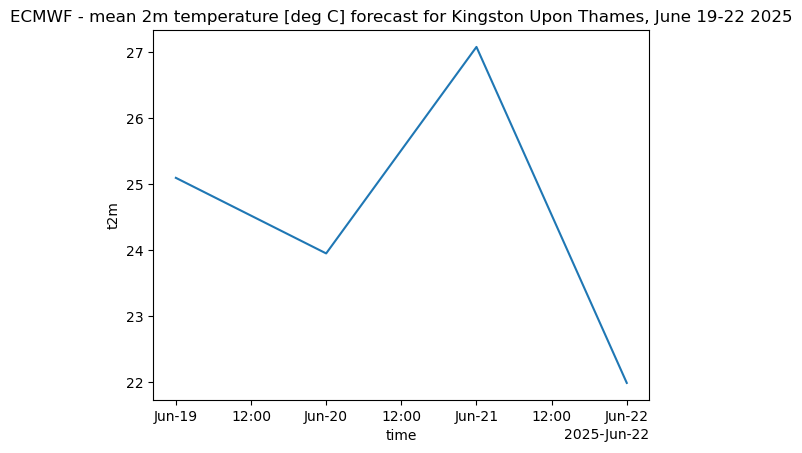

In [17]:
ds_daily_tasmean_19_22June2025['t2m'].sel(longitude = -0.31, latitude = 51.41, method='nearest').plot()
plt.title("ECMWF - mean 2m temperature [deg C] forecast for Kingston Upon Thames, June 19-22 2025")

### Plot the full global gridded Tmean forecast for 21-June-2025

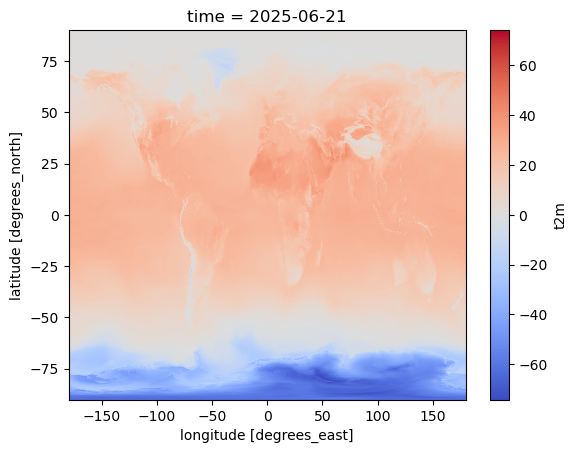

In [18]:
ds_daily_tasmean_19_22June2025.t2m[2].plot(cmap=plt.cm.coolwarm)

### Save this xarray dataset as a global daily Tmean in netcdf and geotiff file formats. Before saving the file, set the CRS to EPSG 4326 as this is missing in the attributes and the orginal data has this CRS.

In [19]:
print(ds_daily_tasmean_19_22June2025.rio.crs)

ds_daily_tasmean_19_22June2025.rio.write_crs("EPSG:4326", inplace=True)
print(ds_daily_tasmean_19_22June2025.rio.crs)

None
EPSG:4326


In [46]:
ds_daily_tasmean_19_22June2025.to_netcdf(path="netcdf/tas_daily_19June_22June_2025.nc", mode='w')
ds_daily_tasmean_19_22June2025["t2m"].rio.to_raster("geotiff/tas_daily_19June_22June_2025.tif")

### Spatial aggregation of gridded Daily Tmean to the LSOA 2011 census boundaries in England & Wales

#### Confirm if the CRS in the ds object is recorded, otherwise it is not possible to reproject it to any other CRS.

In [20]:
print(ds_daily_tasmean_19_22June2025.rio.crs)

EPSG:4326


### Next read the Lower layer Super Output Areas (LSOA) shape files. The LSOA boundaries "Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3" were downloaded from: https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-boundaries-ew-bgc-v3/explore and are saved here:
https://github.com/gasparrini/UK-HWfcast/blob/main/data/lsoashp.zip . 

#### Download and extract the lsoashp.* (four files) in a local directory

#### Alternatively,  the shape file can be downloaded from the Github repo: https://github.com/gasparrini/UK-HWfcast/blob/main/data/lsoashp.zip and read directly from a temporary folder as shown below in Option 2.

In [27]:
#Option 1
LSOA_2011_gdf = gpd.read_file(shape_dir + 'lsoashp.shp')

# Display basic info
print(LSOA_2011_gdf.head())
print("CRS:", LSOA_2011_gdf.crs)

   LSOA11CD   \
0  E01000001   
1  E01000002   
2  E01000003   
3  E01000005   
4  E01000006   

                                                                                                geometry                                                                                               
0                                                 POLYGON ((532282.629 181906.496, 532248.25 181332.036, 531948.314 181471.969, 532022.375 181893.469, 532104.872 182011.888, 532282.629 181906.496))  
1                                                                        POLYGON ((532746.814 181786.892, 532248.25 181332.036, 532282.629 181906.496, 532419.592 181998.305, 532746.814 181786.892))  
2                                                POLYGON ((532293.068 182068.422, 532419.592 181998.305, 532282.629 181906.496, 532104.872 182011.888, 532135.146 182198.119, 532293.068 182068.422))  
3  POLYGON ((533604.245 181418.129, 533743.689 181261.328, 533837.939 180857.859, 533807.947 180767.771

#### Option2: download from the github link, unzip and read and .shp file.

In [32]:
url = 'https://github.com/gasparrini/UK-HWfcast/raw/refs/heads/main/data/lsoashp.zip'

# Create a temporary directory
with tempfile.TemporaryDirectory() as tmpdir:
    # Download the zip file
    zip_path = os.path.join(tmpdir, "shapefile.zip")
    response = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(response.content)

    # Unzip contents
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(tmpdir)
        
    # List extracted files
    extracted_files = os.listdir(tmpdir)
    print("Extracted files are:", extracted_files) 
    
    print("\n ======= LSOA gdf first few rows ===============\n")

    # Find the .shp file inside the extracted folder
    shp_files = [f for f in os.listdir(tmpdir) if f.endswith(".shp")]
    if not shp_files:
        raise FileNotFoundError("\nNo .shp file found in zip folder.")

    shp_path = os.path.join(tmpdir, shp_files[0])

    # Read with geopandas
    LSOA_2011_gdf = gpd.read_file(shp_path)

    # Display basic info
    print(LSOA_2011_gdf.head())
    print("\nCRS is:", LSOA_2011_gdf.crs)

Extracted files are: ['lsoashp.prj', 'lsoashp.shp', 'shapefile.zip', 'lsoashp.shx', 'lsoashp.dbf']

 ======= LSOA gdf first few rows ===============

   LSOA11CD   \
0  E01000001   
1  E01000002   
2  E01000003   
3  E01000005   
4  E01000006   

                                                                                                geometry                                                                                               
0                                                 POLYGON ((532282.629 181906.496, 532248.25 181332.036, 531948.314 181471.969, 532022.375 181893.469, 532104.872 182011.888, 532282.629 181906.496))  
1                                                                        POLYGON ((532746.814 181786.892, 532248.25 181332.036, 532282.629 181906.496, 532419.592 181998.305, 532746.814 181786.892))  
2                                                POLYGON ((532293.068 182068.422, 532419.592 181998.305, 532282.629 181906.496, 532104.872 182011.888, 53

### To spatially aggregate the daily Tmean (xarray ds) to LSOA boundaries, both ds and gdf objects need to be on the same projection. Reproject the clipped ds object using the EPSG string OR using the CRS directly from the gdf (LSOA boundaries). Note that the LSOA has EPSG 27700

In [33]:
ds_daily_tasmean_19_22June2025_epsg_27700 = ds_daily_tasmean_19_22June2025.rio.reproject(LSOA_2011_gdf.crs)
print(ds_daily_tasmean_19_22June2025_epsg_27700.rio.crs)

EPSG:27700


### Use exact_extract function to calculate the area-weighted daily Tmean at LSOA-level. Note: 'mean' is area-weighted in the function. Below block of code will take a few mins to run when the aggregation is done for all time steps of the ds object. The output will be a Pandas df.

In [34]:
# First line is commented as it performs the aggregation only for the first time step.
#LSOA_daily_tasmean_19June2025_df = exact_extract(ds_daily_tasmean_19_22June2025_epsg_27700['t2m'].isel(time=0), LSOA_2011_gdf, 'mean', output='pandas')
LSOA_daily_tasmean_19_22June2025_df = exact_extract(ds_daily_tasmean_19_22June2025_epsg_27700['t2m'], LSOA_2011_gdf, 'mean', include_cols='LSOA11CD', output='pandas')
LSOA_daily_tasmean_19_22June2025_df

/home/lshmm22/anaconda3/envs/ukmo/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


,LSOA11CD,band_1_mean,band_2_mean,band_3_mean,band_4_mean
0,E01000001,24.684811,23.111214,26.838154,22.533993
1,E01000002,24.684811,23.111214,26.838154,22.533993
2,E01000003,24.684811,23.111214,26.838154,22.533993
3,E01000005,24.684811,23.111214,26.838154,22.533993
4,E01000006,24.684811,23.111214,26.838154,22.533993
...,...,...,...,...,...
34748,W01001954,21.395748,22.564339,21.818623,16.436337
34749,W01001955,17.806110,18.869293,18.115723,15.701958
34750,W01001956,17.805904,18.869026,18.115498,15.701962
34751,W01001957,17.805904,18.869026,18.115498,15.701962


### Note: Since the gridded resolution of the ECMWF forecast is 0.25 or ~30km x 30km, and some of the LSOA boundaries are a lot smaller, this means that a common grid cell value is assigned to those nearby boundaries resulting in more than one LSOA having the same forecast temperature for the lead time. 

In [35]:
LSOA_daily_tasmean_19_22June2025_df[["band_1_mean", "band_2_mean", "band_3_mean", "band_4_mean"]] = LSOA_daily_tasmean_19_22June2025_df[["band_1_mean", "band_2_mean", "band_3_mean", "band_4_mean"]].apply(lambda x: round(x, 2))
LSOA_daily_tasmean_19_22June2025_df.columns = ["LSOA11CD", "June19_2025", "June20_2025", "June21_2025", "June22_2025"]
LSOA_daily_tasmean_19_22June2025_df

,LSOA11CD,June19_2025,June20_2025,June21_2025,June22_2025
0,E01000001,24.68,23.11,26.84,22.53
1,E01000002,24.68,23.11,26.84,22.53
2,E01000003,24.68,23.11,26.84,22.53
3,E01000005,24.68,23.11,26.84,22.53
4,E01000006,24.68,23.11,26.84,22.53
...,...,...,...,...,...
34748,W01001954,21.40,22.56,21.82,16.44
34749,W01001955,17.81,18.87,18.12,15.70
34750,W01001956,17.81,18.87,18.12,15.70
34751,W01001957,17.81,18.87,18.12,15.70


### Check for any missing values

In [70]:
LSOA_daily_tasmean_19_22June2025_df.isnull().values.any()

False

In [ ]:
LSOA_daily_tasmean_19_22June2025_df.to_csv(output_csv_filename, sep='\t', index=False, header=True)

### End of the script  